In [1]:
import os
import glob

import numpy as np
import pandas as pd
import parmed as pmd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from tqdm import tqdm
from numpy import linalg as LA
from MDAnalysis.analysis import distances

# energy calculation 
1. Lennard Jones interaction 
$$ 
\sigma_{ij} = \frac{1}{2}  (\sigma_{ii} + \sigma_{jj}) \\
\epsilon_{ij} = \sqrt(\epsilon_{ii} \epsilon_{jj})  \\
V_{LJ}(r_{ij}) = 4 \epsilon_{ij} \left[ \left(\frac{\sigma_{ij}}{r_{ij}} \right)^{12} - \left(\frac{\sigma_{ij}}{r_{ij}} \right)^{6} \right]
$$
2. Coulombic interaction 
$$
V_{C} (r_{ij}) = f \frac{q_i q_j}{\varepsilon_r r_{ij}} \\ 
f = \frac{1}{4 \pi \varepsilon_0} = 139.935485 ~ kJ \cdot mol^{-1} \cdot nm \cdot e^{-2}
$$

In [2]:
def cal_LJ(atom1, atom2, dist): 
    sigma_ij = (atom1.sigma + atom2.sigma) / 2
    epsilon_ij = (atom1.epsilon * atom2.epsilon) ** 0.5
    V_lj = 4 * epsilon_ij * ((sigma_ij/dist)**12 - (sigma_ij/dist)**6) 
    return V_lj


def cal_Coul(atom1, atom2, dist): 
    f = 139.935485 
    q_i = atom1.charge
    q_j = atom2.charge 
    V_coul = f * q_i * q_j / dist 
    return V_coul 

def getForce_LJ_atomgroup(atmgrp1, atmgrp2, dists): 
    # get parameters 
    sigma_i = np.array([atom.sigma for atom in atmgrp1])
    sigma_j = np.array([atom.sigma for atom in atmgrp2])
    eps_i = np.array([atom.epsilon for atom in atmgrp1])
    eps_j = np.array([atom.epsilon for atom in atmgrp2])
    # mesh parameters 
    sigma_i, sigma_j = np.meshgrid(sigma_i, sigma_j, sparse=True)
    eps_i, eps_j = np.meshgrid(eps_i, eps_j, sparse=True)
    # combination
    sigma_ij = (sigma_i + sigma_j) / 2
    eps_ij = (eps_i * eps_j) ** .5 
    C_ij = sigma_ij / dists
    V_lj = 4 * eps_ij *(C_ij**12 - C_ij**6)
    return np.sum(V_lj) 
    
def getForce_Coul_atomgroup(atmgrp1, atmgrp2, dists): 
    f = 139.935485
    # get parameters 
    q_i = np.array([atom.charge for atom in atmgrp1])
    q_j = np.array([atom.charge for atom in atmgrp2])
    # mesh parameters 
    q_i, q_j = np.meshgrid(q_i, q_j, sparse=True)
    # combination
    q_ij = q_i * q_j
    V_coul = f * q_ij / dists
    return np.sum(V_coul) 


In [3]:
runs = sorted(glob.glob("../../traj_save/*//*.pdb"))

In [22]:
df = []

for run in runs[:1]:
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        run_base += '_000'
    print(run_base)
    top_file = f'../../traj_save/top_files/{run_base[:-4]}.top'
    resname = run_base.split('_')[1] if len(run_base.split('_')) > 2 else None

    mda_traj = mda.Universe(pdb_file, dcd_file)
    top = pmd.load_file(top_file, xyz=pdb_file)

    nsp16 = mda_traj.segments[0].atoms
    if resname: 
        nsp16 = nsp16 + mda_traj.select_atoms(f"resname {resname.upper()}") 
    
    nsp10 = mda_traj.select_atoms("segid B")
    ZN = mda_traj.select_atoms("resname ZN")
    nsp10 = nsp10 + ZN
    
    nsp16_top = [top.atoms[i] for i in nsp16.indices]
    nsp10_top = [top.atoms[i] for i in nsp10.indices]
#     nsp10_
    dist_list = []
    for ts in tqdm(mda_traj.trajectory[:]):
        dist_map  = distances.distance_array(
                nsp10.positions, nsp16.positions, box = ts.dimensions) 
        V_LJ = getForce_LJ_atomgroup(nsp16_top, nsp10_top, dist_map)
        V_coul = getForce_Coul_atomgroup(nsp16_top, nsp10_top, dist_map)
        
        df.append({'sys_name': run_base,
                    'frame': ts.frame,
    #                    'dist_vec': dist_vec,
                   'V_LJ': V_LJ, 'V_coul': V_coul})

comp_000


  0%|          | 29/10000 [00:19<1:50:59,  1.50it/s]


KeyboardInterrupt: 

In [6]:
df.to_pickle('dist_nsp10-16.pkl')

In [8]:
sorted(df.sys_name.unique())

['comp_000',
 'comp_005',
 'comp_010',
 'comp_015',
 'comp_020',
 'comp_025',
 'comp_030',
 'comp_035',
 'comp_040',
 'comp_045',
 'comp_050',
 'comp_055',
 'comp_060',
 'comp_065',
 'comp_070',
 'comp_075',
 'comp_080',
 'comp_085',
 'comp_090',
 'comp_095',
 'comp_100',
 'comp_sah_000',
 'comp_sah_005',
 'comp_sah_010',
 'comp_sah_015',
 'comp_sah_020',
 'comp_sah_025',
 'comp_sah_030',
 'comp_sah_035',
 'comp_sah_040',
 'comp_sah_045',
 'comp_sah_050',
 'comp_sah_055',
 'comp_sah_060',
 'comp_sah_065',
 'comp_sah_070',
 'comp_sah_075',
 'comp_sah_080',
 'comp_sah_085',
 'comp_sah_090',
 'comp_sah_095',
 'comp_sah_100',
 'comp_sam_000',
 'comp_sam_005',
 'comp_sam_010',
 'comp_sam_015',
 'comp_sam_020',
 'comp_sam_025',
 'comp_sam_030',
 'comp_sam_035',
 'comp_sam_040',
 'comp_sam_045',
 'comp_sam_050',
 'comp_sam_055',
 'comp_sam_060',
 'comp_sam_065',
 'comp_sam_070',
 'comp_sam_075',
 'comp_sam_080',
 'comp_sam_085',
 'comp_sam_090',
 'comp_sam_095',
 'comp_sam_100',
 'comp_sfg_00

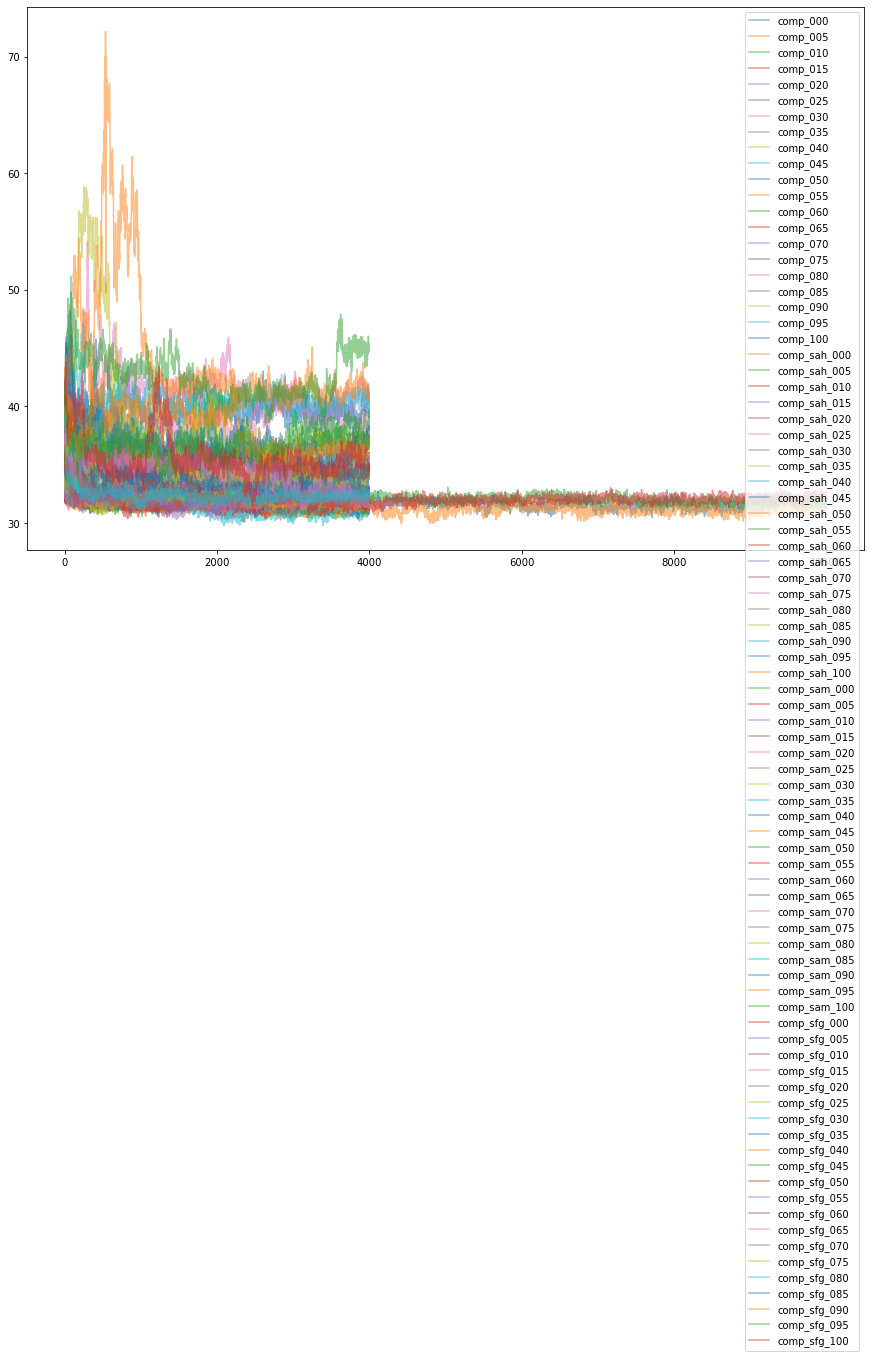

In [12]:
fig, axes = plt.subplots( figsize=(15,10)) 
n_traj = 0 

for sys_name in sorted(df.sys_name.unique()): 
    sub_df = df[df['sys_name'] == sys_name]
    axes.plot(sub_df['frame'], sub_df['dist'], label=sys_name, alpha=.5) 
plt.legend()
plt.savefig('dist.pdf')